In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from tensorflow import keras
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Bidirectional
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import KFold
import os

In [2]:
data_five_minute = pd.read_excel("BRENT VOL.xlsx", sheet_name = "5M")
data_five_minute = data_five_minute.iloc[2:, 1:3]
data_five_minute.columns = ["Date", "Price"]
data_five_minute["Date"] = pd.to_datetime(data_five_minute["Date"])
data_five_minute['Price'] = pd.to_numeric(data_five_minute['Price'], errors='coerce')
data_five_minute.set_index("Date", inplace = True)

data_five_minute.head()

,Price
Date,
2023-11-06 06:05:00,85.33
2023-11-06 06:10:00,85.31
2023-11-06 06:15:00,85.30
2023-11-06 06:20:00,85.34
2023-11-06 06:25:00,85.34


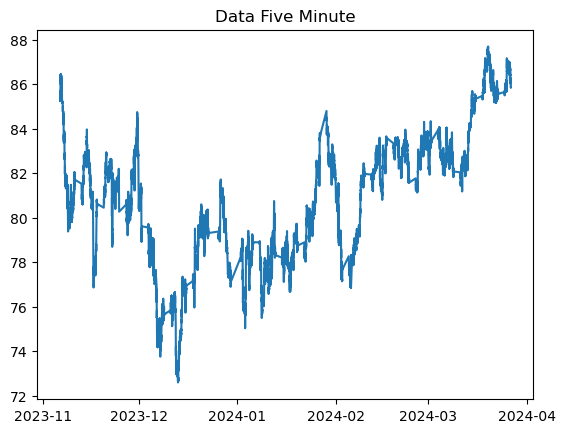

In [3]:
plt.plot(data_five_minute['Price'])
plt.title('Data Five Minute')
plt.show()

In [4]:
# Some descriptive statistics of the data

data_five_minute_stats = data_five_minute["Price"].describe()
display(data_five_minute_stats)

count    25664.000000
mean        80.745708
std          2.976883
min         72.590000
25%         78.420000
50%         81.050000
75%         82.760000
max         87.700000
Name: Price, dtype: float64

In [5]:
train_size_five = int(len(data_five_minute) * 0.70)
validation_size_five = int(len(data_five_minute) * 0.15)

train_data_five = data_five_minute[:train_size_five]
validation_data_five = data_five_minute[train_size_five:train_size_five + validation_size_five]
test_data_five = data_five_minute[train_size_five + validation_size_five:]

scaler = MinMaxScaler()
scaler_five = scaler.fit(train_data_five[["Price"]])
training_scaled_five = scaler_five.transform(train_data_five[["Price"]])
validation_scaled_five = scaler.transform(validation_data_five[["Price"]])
test_scaled_five = scaler.transform(test_data_five[["Price"]])

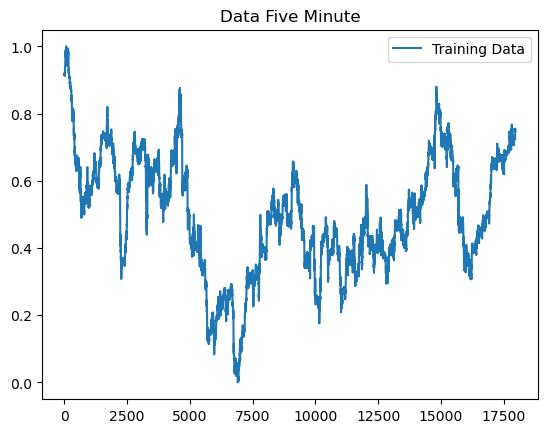

In [6]:
# Quick check of the scaled data (training set)

plt.plot(training_scaled_five, label='Training Data')
plt.legend(loc="upper right")
plt.title('Data Five Minute')

plt.show()


In [7]:
# Creating sequences for the model 
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        sequence = data[i:i + sequence_length]
        label = data[i + sequence_length]
        X.append(sequence)
        y.append(label)
    return np.array(X), np.array(y)

base_sequence_length = 20 # Here we set the sequence length to whatever we want, depending on what we have at hand

X_train_five , y_train_five = create_sequences(training_scaled_five, base_sequence_length)
X_val_five , y_val_five = create_sequences(validation_scaled_five, base_sequence_length)
X_test_five , y_test_five = create_sequences(test_scaled_five, base_sequence_length)


In [8]:
def fit_model(model, epochs=100, batch_size=32):
    model_history = model.fit(
    X_train_five, y_train_five,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val_five, y_val_five),
    verbose=1,
    callbacks=[EarlyStopping(patience=10, restore_best_weights=True)]
    )
    return model_history


In [9]:
def evaluate_model_performance(model, X_test=X_test_five, y_test=y_test_five, initial_capital=10000000):

    predicted_prices = model.predict(X_test)
    predicted_prices = scaler.inverse_transform(predicted_prices)

    trades = []
    for i in range(len(predicted_prices) - 1):
        if predicted_prices[i + 1] > predicted_prices[i]:
            trades.append('buy')
        else:
            trades.append('sell')

    capital = initial_capital
    positions = 0 
    portfolio_value = [initial_capital] 
    returns = []
    gains = []

    for i, trade in enumerate(trades):
        current_price_scaled = X_test[i, -1, 0].reshape(-1, 1)
        current_price = scaler.inverse_transform(current_price_scaled)
        current_price = current_price[0, 0]

        if trade == 'buy' and capital >= current_price:
            q = capital // current_price
            if q > 0:
                capital -= q * current_price
                positions += q

        elif trade == 'sell' and positions > 0:
            capital += positions * current_price
            gains.append(positions * current_price - initial_capital)
            positions = 0

        portfolio_value.append(capital + positions * current_price)

        if i > 0:
            step_return = (portfolio_value[-1] - portfolio_value[-2]) / portfolio_value[-2]
            returns.append(step_return)

    cumulative_returns = np.cumprod(np.array(returns) + 1) - 1
    final_capital = capital + positions * current_price
    total_return = (final_capital - initial_capital) / initial_capital

    peak = np.maximum.accumulate(portfolio_value)
    drawdown = (peak - portfolio_value) / peak
    fig, axes = plt.subplots(3, 2, figsize=(15, 15))

    print(f"The final portfolio value is: {final_capital}")
    print(f"The total return is: {total_return}")
    print(f"The maximum drawdown is: {np.max(drawdown)}")
    
    actual_prices = scaler.inverse_transform(X_test[:, -1, 0].reshape(-1, 1))
    axes[0, 0].plot(actual_prices, label='Actual prices')
    axes[0, 0].plot(predicted_prices, label='Predicted prices')
    axes[0, 0].legend()
    axes[0, 0].set_title('Actual vs Predicted Prices')
    axes[0, 0].set_xlabel('Time')
    axes[0, 0].set_ylabel('Price')

    axes[0, 1].plot(cumulative_returns, label='Cumulative Returns')
    axes[0, 1].legend()
    axes[0, 1].set_title('Cumulative Returns')
    axes[0, 1].set_xlabel('Time')
    axes[0, 1].set_ylabel('Cumulative Return')

    spread = actual_prices - predicted_prices
    axes[1, 0].hist(spread, label='Spread', bins=50, alpha=0.7, color='red', edgecolor='black')
    axes[1, 0].legend()
    axes[1, 0].set_title('Spread between Actual and Predicted Prices')
    axes[1, 0].set_xlabel('Spread')
    axes[1, 0].set_ylabel('Frequency')

    axes[1, 1].plot(returns, label='Returns')
    axes[1, 1].legend()
    axes[1, 1].set_title('Returns')
    axes[1, 1].set_xlabel('Time')
    axes[1, 1].set_ylabel('Return')

    axes[2, 0].plot(drawdown, label='Drawdown', color='orange')
    axes[2, 0].legend()
    axes[2, 0].set_title('Drawdown')
    axes[2, 0].set_xlabel('Time')
    axes[2, 0].set_ylabel('Drawdown')

    sns.histplot(returns, kde=True, bins=50, color='blue', ax=axes[2, 1])
    axes[2, 1].set_title('Distribution of Returns')
    axes[2, 1].set_xlabel('Returns')
    axes[2, 1].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

    

In [10]:
def plot_loss_history(model_history):

    plt.plot(model_history.history['loss'], label='Training Loss')
    plt.plot(model_history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [11]:
# Naive model with LSTM with two layers
def LSTM_creator():
    LSTM_model = Sequential([
        LSTM(units=50, return_sequences=True, input_shape=(None, 1)),
        Dropout(0.2),
        LSTM(units=50, return_sequences=False),
        Dropout(0.2),
        Dense(units=1)
    ])

    LSTM_model.compile(optimizer='adam', loss='mean_squared_error')

    return LSTM_model

In [12]:
LSTM_model = LSTM_creator()

In [13]:
LSTM_model_fit = fit_model(LSTM_model, epochs=100, batch_size=32)

Epoch 1/100
561/561 [==============================] - 9s 11ms/step - loss: 0.0035 - val_loss: 1.7966e-04
Epoch 2/100
561/561 [==============================] - 6s 10ms/step - loss: 0.0016 - val_loss: 1.2999e-04
Epoch 3/100
561/561 [==============================] - 6s 10ms/step - loss: 0.0012 - val_loss: 8.4813e-04
Epoch 4/100
561/561 [==============================] - 6s 10ms/step - loss: 9.8643e-04 - val_loss: 1.6448e-04
Epoch 5/100
561/561 [==============================] - 6s 10ms/step - loss: 7.2950e-04 - val_loss: 9.5030e-05
Epoch 6/100
561/561 [==============================] - 5s 10ms/step - loss: 5.9987e-04 - val_loss: 2.5599e-04
Epoch 7/100
561/561 [==============================] - 6s 10ms/step - loss: 4.6600e-04 - val_loss: 9.7505e-05
Epoch 8/100
561/561 [==============================] - 6s 10ms/step - loss: 4.0786e-04 - val_loss: 7.4497e-05
Epoch 9/100
561/561 [==============================] - 6s 10ms/step - loss: 3.6617e-04 - val_loss: 6.2977e-05
Epoch 10/100
561/561 [

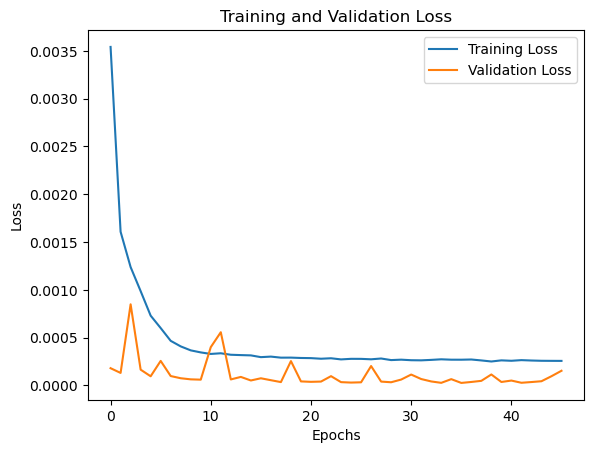

In [14]:
plot_loss_history(LSTM_model_fit)

120/120 [==============================] - 1s 3ms/step
The final portfolio value is: 25435028.230000015
The total return is: 1.5435028230000016
The maximum drawdown is: 0.00023871854858434135


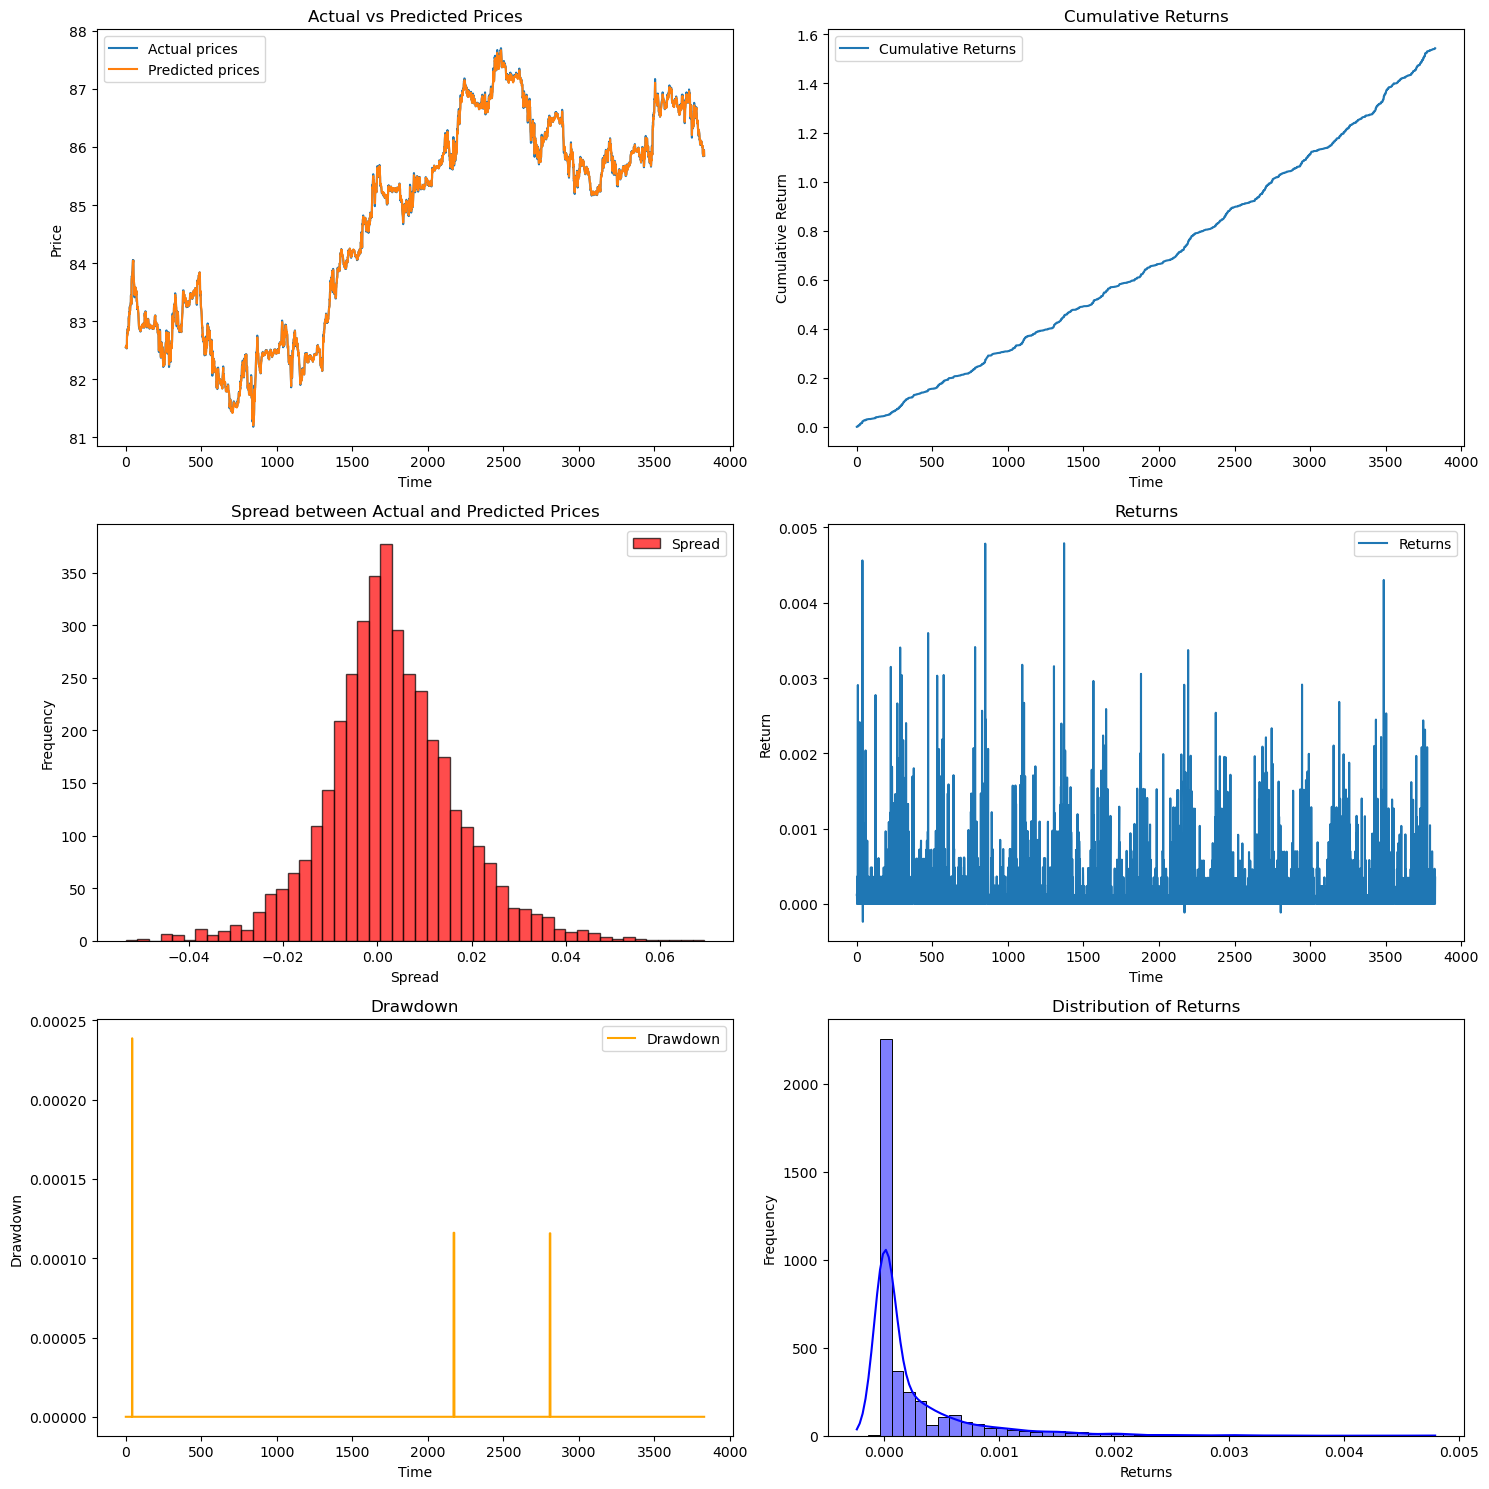

In [15]:
evaluate_model_performance(LSTM_model)

In [35]:
def fit_model_kfold(model_creator, X, y, epochs=100, batch_size=32, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_no = 1
    history_list = []
    best_val_loss = float('inf')
    best_model = None
    model_dir = 'kfold_models'
    
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)
    
    for train_index, val_index in kf.split(X):
        print(f'Training fold {fold_no}...')
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        
        model = model_creator
        
        model_history = fit_model(model)
        
        model_path = os.path.join(model_dir, f'model_fold_{fold_no}.h5')
        model.save(model_path)
        
        history_list.append(model_history)
     
        val_loss = model_history.history['val_loss'][-1]
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_models = model_path
        
        fold_no += 1
    
    plot_loss_history_kfold(history_list)
    best_trained_models = tf.keras.models.load_model(best_models)
    
    # Return the histories and the best model
    return history_list, best_trained_models

# Function to plot training and validation loss across folds
def plot_loss_history_kfold(history_list, title='Training and Validation Loss Across Folds'):
    plt.figure(figsize=(12, 6))
    for i, history in enumerate(history_list):
        plt.plot(history.history['loss'], label=f'Training Loss Fold {i+1}')
        plt.plot(history.history['val_loss'], label=f'Validation Loss Fold {i+1}')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


X_combined = np.concatenate((X_train_five, X_val_five), axis=0)
y_combined = np.concatenate((y_train_five, y_val_five), axis=0)




Training fold 1...
Epoch 1/100
561/561 [==============================] - 11s 13ms/step - loss: 0.0049 - val_loss: 0.0018
Epoch 2/100
561/561 [==============================] - 7s 12ms/step - loss: 0.0017 - val_loss: 1.5719e-04
Epoch 3/100
561/561 [==============================] - 6s 11ms/step - loss: 0.0014 - val_loss: 1.6544e-04
Epoch 4/100
561/561 [==============================] - 6s 11ms/step - loss: 0.0011 - val_loss: 2.8609e-04
Epoch 5/100
561/561 [==============================] - 6s 11ms/step - loss: 8.2804e-04 - val_loss: 1.2815e-04
Epoch 6/100
561/561 [==============================] - 7s 12ms/step - loss: 6.5489e-04 - val_loss: 4.9403e-04
Epoch 7/100
561/561 [==============================] - 7s 12ms/step - loss: 5.1941e-04 - val_loss: 3.4113e-04
Epoch 8/100
561/561 [==============================] - 7s 13ms/step - loss: 4.4867e-04 - val_loss: 1.1376e-04
Epoch 9/100
561/561 [==============================] - 7s 12ms/step - loss: 3.8576e-04 - val_loss: 1.4809e-04
Epoch 10/1

C:\Users\salih\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


561/561 [==============================] - 7s 13ms/step - loss: 2.6284e-04 - val_loss: 1.1460e-04
Epoch 2/100
561/561 [==============================] - 7s 12ms/step - loss: 2.6878e-04 - val_loss: 2.3564e-04
Epoch 3/100
561/561 [==============================] - 7s 12ms/step - loss: 2.6483e-04 - val_loss: 2.1662e-04
Epoch 4/100
561/561 [==============================] - 7s 12ms/step - loss: 2.6286e-04 - val_loss: 2.6642e-05
Epoch 5/100
561/561 [==============================] - 7s 12ms/step - loss: 2.6022e-04 - val_loss: 1.1677e-04
Epoch 6/100
561/561 [==============================] - 7s 12ms/step - loss: 2.5308e-04 - val_loss: 3.4852e-05
Epoch 7/100
561/561 [==============================] - 7s 12ms/step - loss: 2.5565e-04 - val_loss: 9.0872e-05
Epoch 8/100
561/561 [==============================] - 7s 12ms/step - loss: 2.5815e-04 - val_loss: 6.9233e-05
Epoch 9/100
561/561 [==============================] - 7s 12ms/step - loss: 2.6097e-04 - val_loss: 4.8338e-05
Epoch 10/100
561/561 [

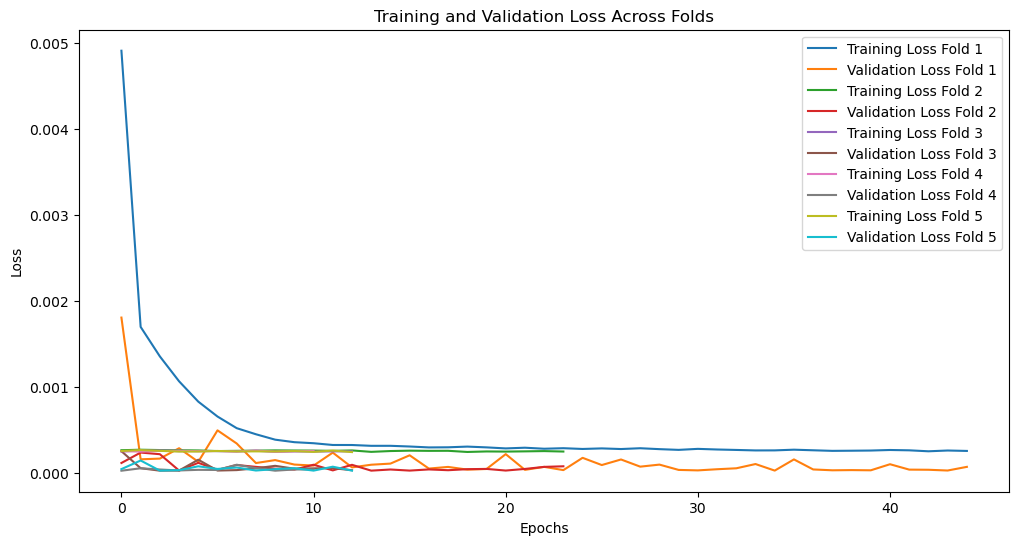

In [37]:
history_list, best_trained_models = fit_model_kfold(LSTM_creator(), X_combined, y_combined, batch_size=32, n_splits=5)

In [38]:
best_trained_models.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, None, 50)          10400     
                                                                 
 dropout_4 (Dropout)         (None, None, 50)          0         
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_5 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 30651 (119.73 KB)
Trainable params: 30651 (119.73 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


120/120 [==============================] - 1s 4ms/step
The final portfolio value is: 25441509.470000077
The total return is: 1.5441509470000077
The maximum drawdown is: 0.00011653633020268004


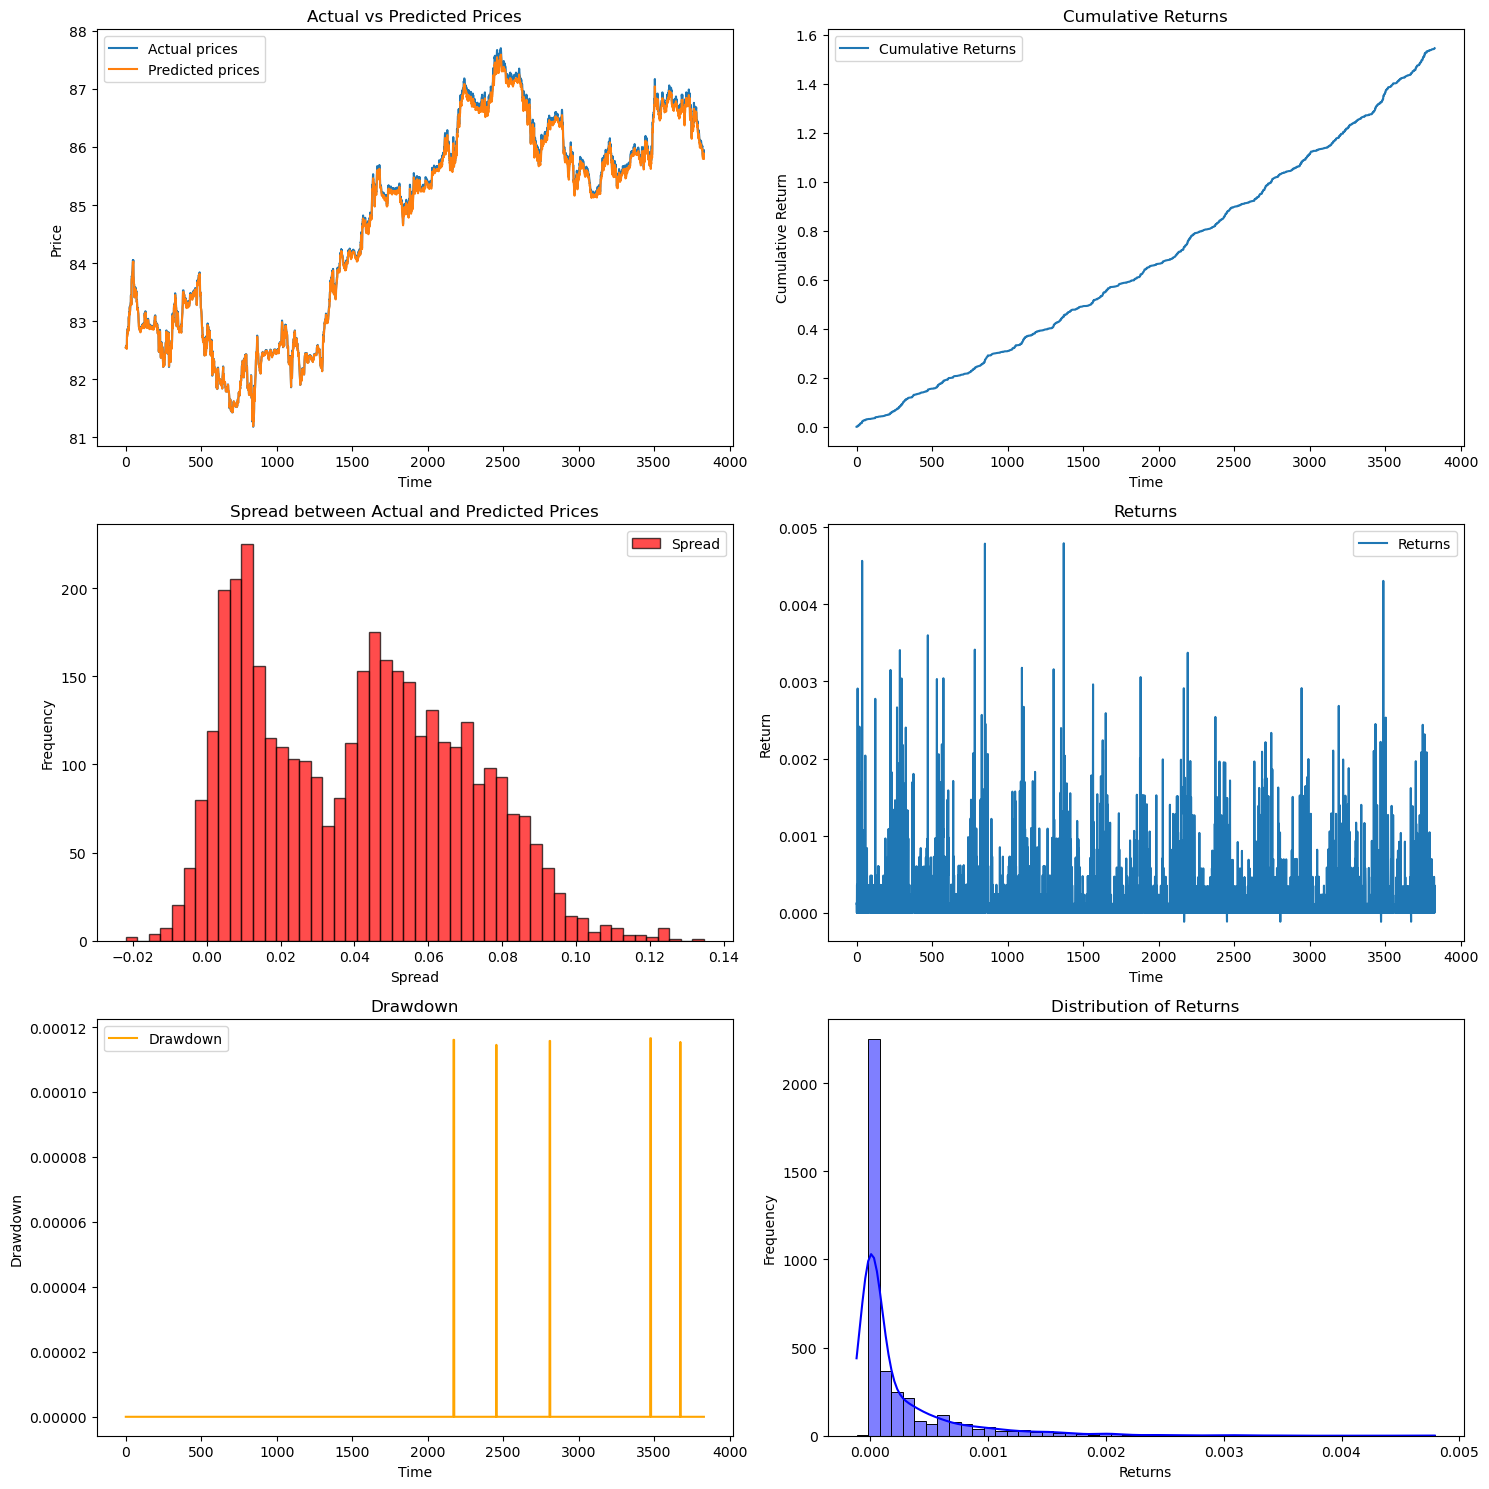

INFO:tensorflow:Assets written to: LSTM K-Fold Model\assets


INFO:tensorflow:Assets written to: LSTM K-Fold Model\assets


In [40]:
evaluate_model_performance(best_trained_models)
best_trained_models.save('LSTM K-Fold Model')

In [41]:
import numpy as np
import autokeras as ak
from tensorflow.keras.callbacks import EarlyStopping


# Define the AutoKeras model
input_node = ak.Input()  # Ensure this is the correct input type for your data
output_node = ak.RNNBlock(return_sequences=False)(input_node)
output_node = ak.RegressionHead()(output_node)
model = ak.AutoModel(
    inputs=input_node, outputs=output_node, overwrite=True, max_trials=60
)

print('Training the model...')
model.fit(X_train_five, y_train_five, epochs=80, validation_data=(X_val_five, y_val_five), 
          callbacks=[EarlyStopping(patience=10, restore_best_weights=True)])

print('Evaluating the model...')
loss, mae = model.evaluate(X_val_five, y_val_five)
print('Loss:', loss)
print('MAE:', mae)

Training the model...


Exception ignored in: <function AtomicFunction.__del__ at 0x00000161206EF740>
Traceback (most recent call last):
  File "C:\Users\salih\AppData\Roaming\Python\Python311\site-packages\tensorflow\python\eager\polymorphic_function\atomic_function.py", line 282, in __del__
    key = (self._bound_context.function_scope_id, self.name)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\salih\AppData\Roaming\Python\Python311\site-packages\tensorflow\python\eager\context.py", line 1464, in function_scope_id
    @property
  
KeyboardInterrupt: 



Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
True              |True              |rnn_block_1/bidirectional
lstm              |lstm              |rnn_block_1/layer_type
2                 |2                 |rnn_block_1/num_layers
0                 |0                 |regression_head_1/dropout
adam              |adam              |optimizer
2e-05             |2e-05             |learning_rate

Epoch 1/80
559/561 [============================>.] - ETA: 0s - loss: 0.3730 - mean_squared_error: 0.3730

KeyboardInterrupt: 

In [57]:
from keras.models import Model
from keras.layers import Input, Bidirectional, GRU, Dropout, Dense
from keras.optimizers import Adam
input_shape=(None, X_train_five.shape[2])

def create_model(units=64, learning_rate=0.0001, dropout_rate=0):
    inputs = Input(shape=input_shape)
    x = Bidirectional(GRU(units=units, return_sequences=False))(inputs)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(1)(x)
    model = Model(inputs=inputs, outputs=outputs)

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model


In [60]:
gru_model = create_model(units=64, dropout_rate=0.0)
fit_model(gru_model, epochs=300, batch_size=32)

Epoch 1/300
561/561 [==============================] - 11s 10ms/step - loss: 0.0148 - mae: 0.0707 - val_loss: 9.1424e-04 - val_mae: 0.0267
Epoch 2/300
561/561 [==============================] - 5s 8ms/step - loss: 5.4014e-04 - mae: 0.0169 - val_loss: 2.2310e-04 - val_mae: 0.0103
Epoch 3/300
561/561 [==============================] - 5s 8ms/step - loss: 3.6554e-04 - mae: 0.0134 - val_loss: 1.9273e-04 - val_mae: 0.0095
Epoch 4/300
561/561 [==============================] - 4s 8ms/step - loss: 3.2031e-04 - mae: 0.0126 - val_loss: 1.6633e-04 - val_mae: 0.0089
Epoch 5/300
561/561 [==============================] - 5s 8ms/step - loss: 2.7473e-04 - mae: 0.0116 - val_loss: 1.4977e-04 - val_mae: 0.0089
Epoch 6/300
561/561 [==============================] - 4s 7ms/step - loss: 2.3105e-04 - mae: 0.0106 - val_loss: 1.1322e-04 - val_mae: 0.0075
Epoch 7/300
561/561 [==============================] - 4s 8ms/step - loss: 1.9361e-04 - mae: 0.0097 - val_loss: 9.9098e-05 - val_mae: 0.0072
Epoch 8/300
561

120/120 [==============================] - 2s 4ms/step
The final portfolio value is: 25339887.459999986
The total return is: 1.5339887459999986
The maximum drawdown is: 0.00035807959059504257


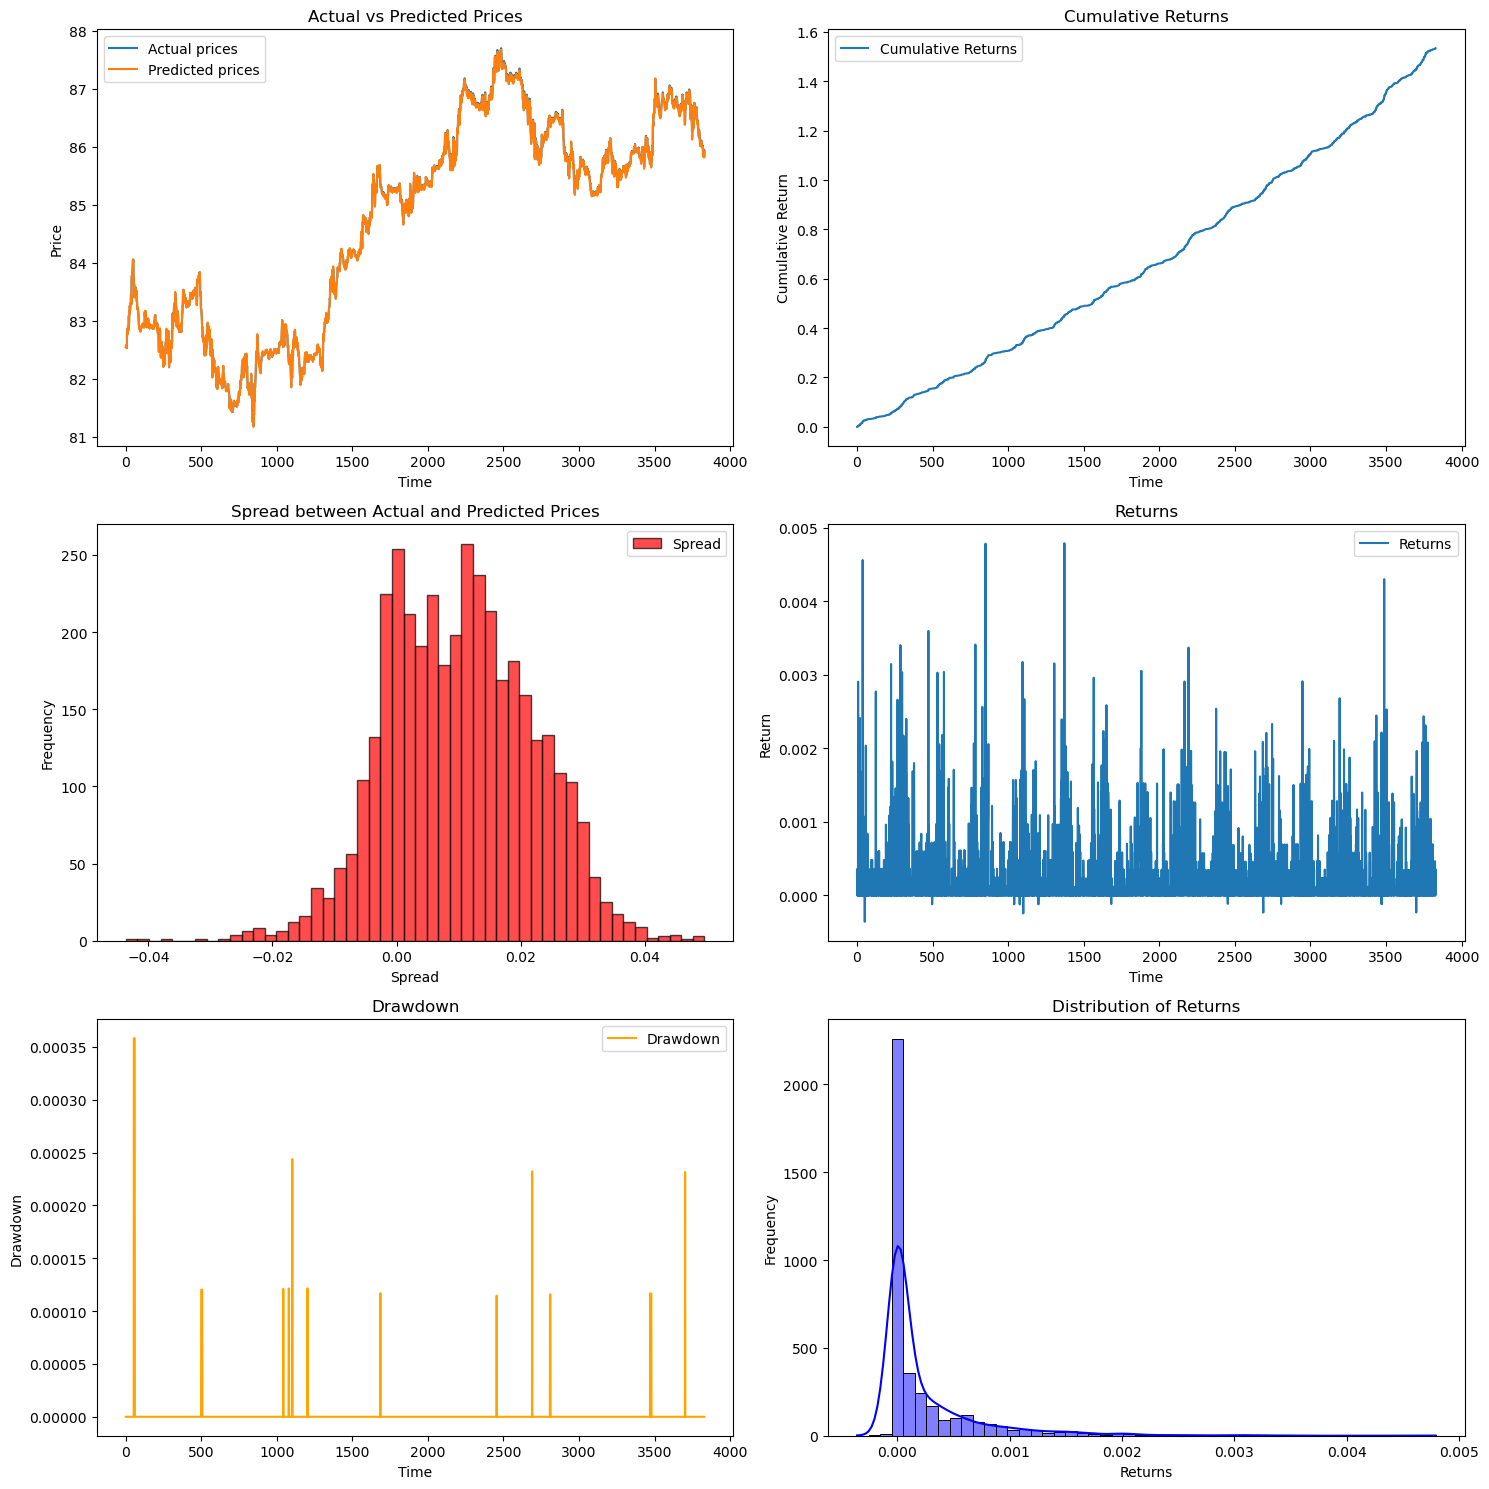

In [61]:
evaluate_model_performance(gru_model)


In [75]:
from keras_tuner import HyperModel, RandomSearch

class MyHyperModel(HyperModel):
    def build(self, hp):
        units = hp.Int('units', min_value=64, max_value=256, step=64)
        dropout_rate = hp.Float('dropout_rate', min_value=0, max_value=0.5, step=0.1)
        learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

        return create_model(units=units, learning_rate=learning_rate, dropout_rate=dropout_rate)

hypermodel = MyHyperModel()

tuner = RandomSearch(
    hypermodel,
    objective='val_mae',
    max_trials=20,
    executions_per_trial=2,
    directory='my_dir',
    project_name='gru_tuning'
)

tuner.search(X_train_five, y_train_five, epochs=100, validation_data=(X_val_five, y_val_five), callbacks=[EarlyStopping(patience=10, restore_best_weights=True)])


Reloading Tuner from my_dir\gru_tuning\tuner0.json


In [76]:
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters:")
for param, value in best_hp.values.items():
    print(f"{param}: {value}")

best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()
best_model.fit(X_train_five, y_train_five, epochs=100, validation_data=(X_val_five, y_val_five), callbacks=[EarlyStopping(patience=10, restore_best_weights=True)])

best_model.save('best_model.h5')
gru_model = keras


Best Hyperparameters:
units: 256
dropout_rate: 0.2
learning_rate: 0.0001
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 1)]         0         
                                                                 
 bidirectional (Bidirection  (None, 512)               397824    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 1)                 513       
                                                                 
Total params: 398337 (1.52 MB)
Trainable params: 398337 (1.52 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
561/56

In [81]:
best_model.get_config()

{'name': 'model',
 'trainable': True,
 'layers': [{'module': 'keras.layers',
   'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, None, 1),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'input_1'},
   'registered_name': None,
   'name': 'input_1',
   'inbound_nodes': []},
  {'module': 'keras.layers',
   'class_name': 'Bidirectional',
   'config': {'name': 'bidirectional',
    'trainable': True,
    'dtype': 'float32',
    'layer': {'module': 'keras.layers',
     'class_name': 'GRU',
     'config': {'name': 'gru',
      'trainable': True,
      'dtype': 'float32',
      'return_sequences': False,
      'return_state': False,
      'go_backwards': False,
      'stateful': False,
      'unroll': False,
      'time_major': False,
      'units': 256,
      'activation': 'tanh',
      'recurrent_activation': 'sigmoid',
      'use_bias': True,
      'kernel_initializer': {'module': 'keras.initializers',
       'class_name': 'GlorotUniform',


120/120 [==============================] - 4s 15ms/step
The final portfolio value is: 25325426.030000057
The total return is: 1.5325426030000058
The maximum drawdown is: 0.0002437826783881332


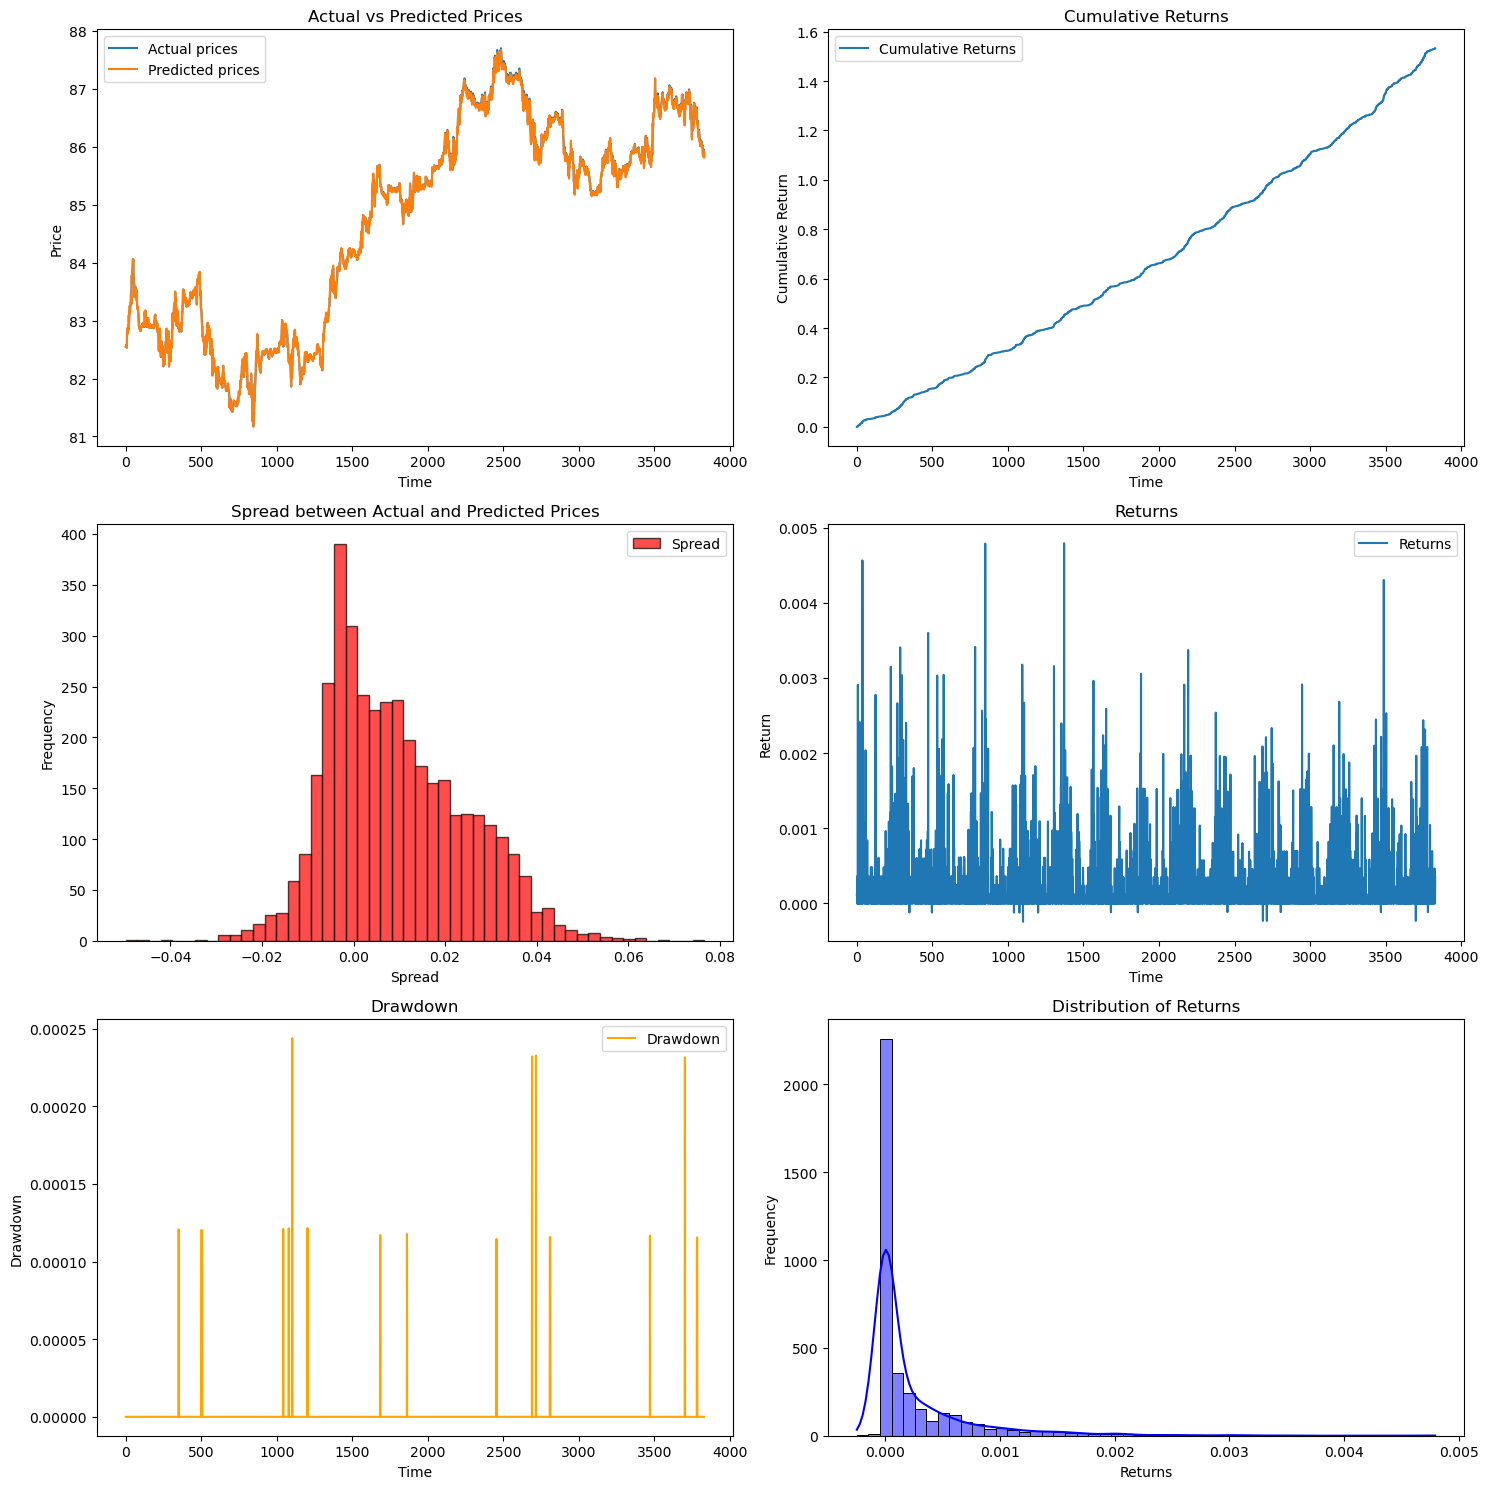

In [77]:
evaluate_model_performance(best_model)

In [78]:
# To retrieve the best parameters found by tuner
tuner_model = tf.keras.models.load_model('best_model.h5')
tuner_model.get_config()

{'name': 'model',
 'trainable': True,
 'layers': [{'module': 'keras.layers',
   'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, None, 1),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'input_1'},
   'registered_name': None,
   'name': 'input_1',
   'inbound_nodes': []},
  {'module': 'keras.layers',
   'class_name': 'Bidirectional',
   'config': {'name': 'bidirectional',
    'trainable': True,
    'dtype': 'float32',
    'layer': {'module': 'keras.layers',
     'class_name': 'GRU',
     'config': {'name': 'gru',
      'trainable': True,
      'dtype': 'float32',
      'return_sequences': False,
      'return_state': False,
      'go_backwards': False,
      'stateful': False,
      'unroll': False,
      'time_major': False,
      'units': 256,
      'activation': 'tanh',
      'recurrent_activation': 'sigmoid',
      'use_bias': True,
      'kernel_initializer': {'module': 'keras.initializers',
       'class_name': 'GlorotUniform',


Training fold 1...
Epoch 1/100
561/561 [==============================] - 39s 54ms/step - loss: 0.0053 - mae: 0.0320 - val_loss: 1.9431e-04 - val_mae: 0.0095
Epoch 2/100
561/561 [==============================] - 30s 53ms/step - loss: 3.0254e-04 - mae: 0.0122 - val_loss: 1.5786e-04 - val_mae: 0.0086
Epoch 3/100
561/561 [==============================] - 29s 51ms/step - loss: 2.4682e-04 - mae: 0.0110 - val_loss: 1.6438e-04 - val_mae: 0.0099
Epoch 4/100
561/561 [==============================] - 28s 50ms/step - loss: 1.9702e-04 - mae: 0.0098 - val_loss: 9.8348e-05 - val_mae: 0.0068
Epoch 5/100
561/561 [==============================] - 29s 51ms/step - loss: 1.5444e-04 - mae: 0.0087 - val_loss: 7.5408e-05 - val_mae: 0.0058
Epoch 6/100
561/561 [==============================] - 28s 50ms/step - loss: 1.2509e-04 - mae: 0.0077 - val_loss: 7.9873e-05 - val_mae: 0.0066
Epoch 7/100
561/561 [==============================] - 28s 50ms/step - loss: 1.0515e-04 - mae: 0.0071 - val_loss: 5.8538e-05 - 

C:\Users\salih\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Training fold 2...
Epoch 1/100
561/561 [==============================] - 30s 54ms/step - loss: 4.2568e-05 - mae: 0.0044 - val_loss: 2.3859e-05 - val_mae: 0.0030
Epoch 2/100
561/561 [==============================] - 32s 56ms/step - loss: 4.2170e-05 - mae: 0.0043 - val_loss: 4.0653e-05 - val_mae: 0.0051
Epoch 3/100
561/561 [==============================] - 34s 60ms/step - loss: 4.0608e-05 - mae: 0.0042 - val_loss: 2.6570e-05 - val_mae: 0.0034
Epoch 4/100
561/561 [==============================] - 30s 53ms/step - loss: 4.0107e-05 - mae: 0.0042 - val_loss: 2.4505e-05 - val_mae: 0.0032
Epoch 5/100
561/561 [==============================] - 33s 59ms/step - loss: 4.0246e-05 - mae: 0.0042 - val_loss: 2.6535e-05 - val_mae: 0.0034
Epoch 6/100
561/561 [==============================] - 30s 54ms/step - loss: 4.0534e-05 - mae: 0.0042 - val_loss: 2.4577e-05 - val_mae: 0.0032
Epoch 7/100
561/561 [==============================] - 30s 53ms/step - loss: 4.0147e-05 - mae: 0.0042 - val_loss: 2.9005e-0

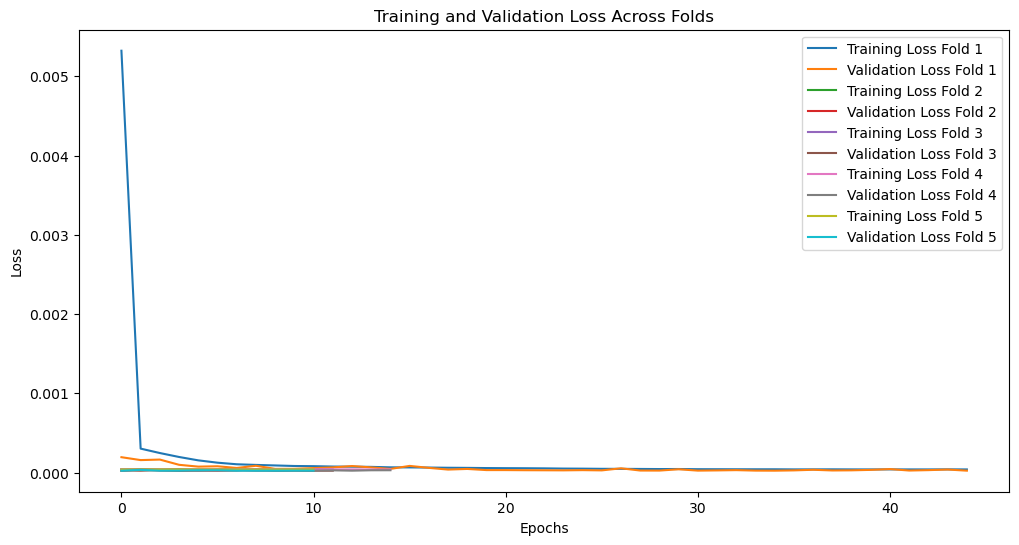

In [130]:
kfold_gru_history, kfold_gru_models = fit_model_kfold(create_model(units=256, dropout_rate=0.0), X_combined, y_combined, batch_size=32, n_splits=5)

120/120 [==============================] - 6s 46ms/step
The final portfolio value is: 25438102.20000001
The total return is: 1.543810220000001
The maximum drawdown is: 0.00011450801081013056


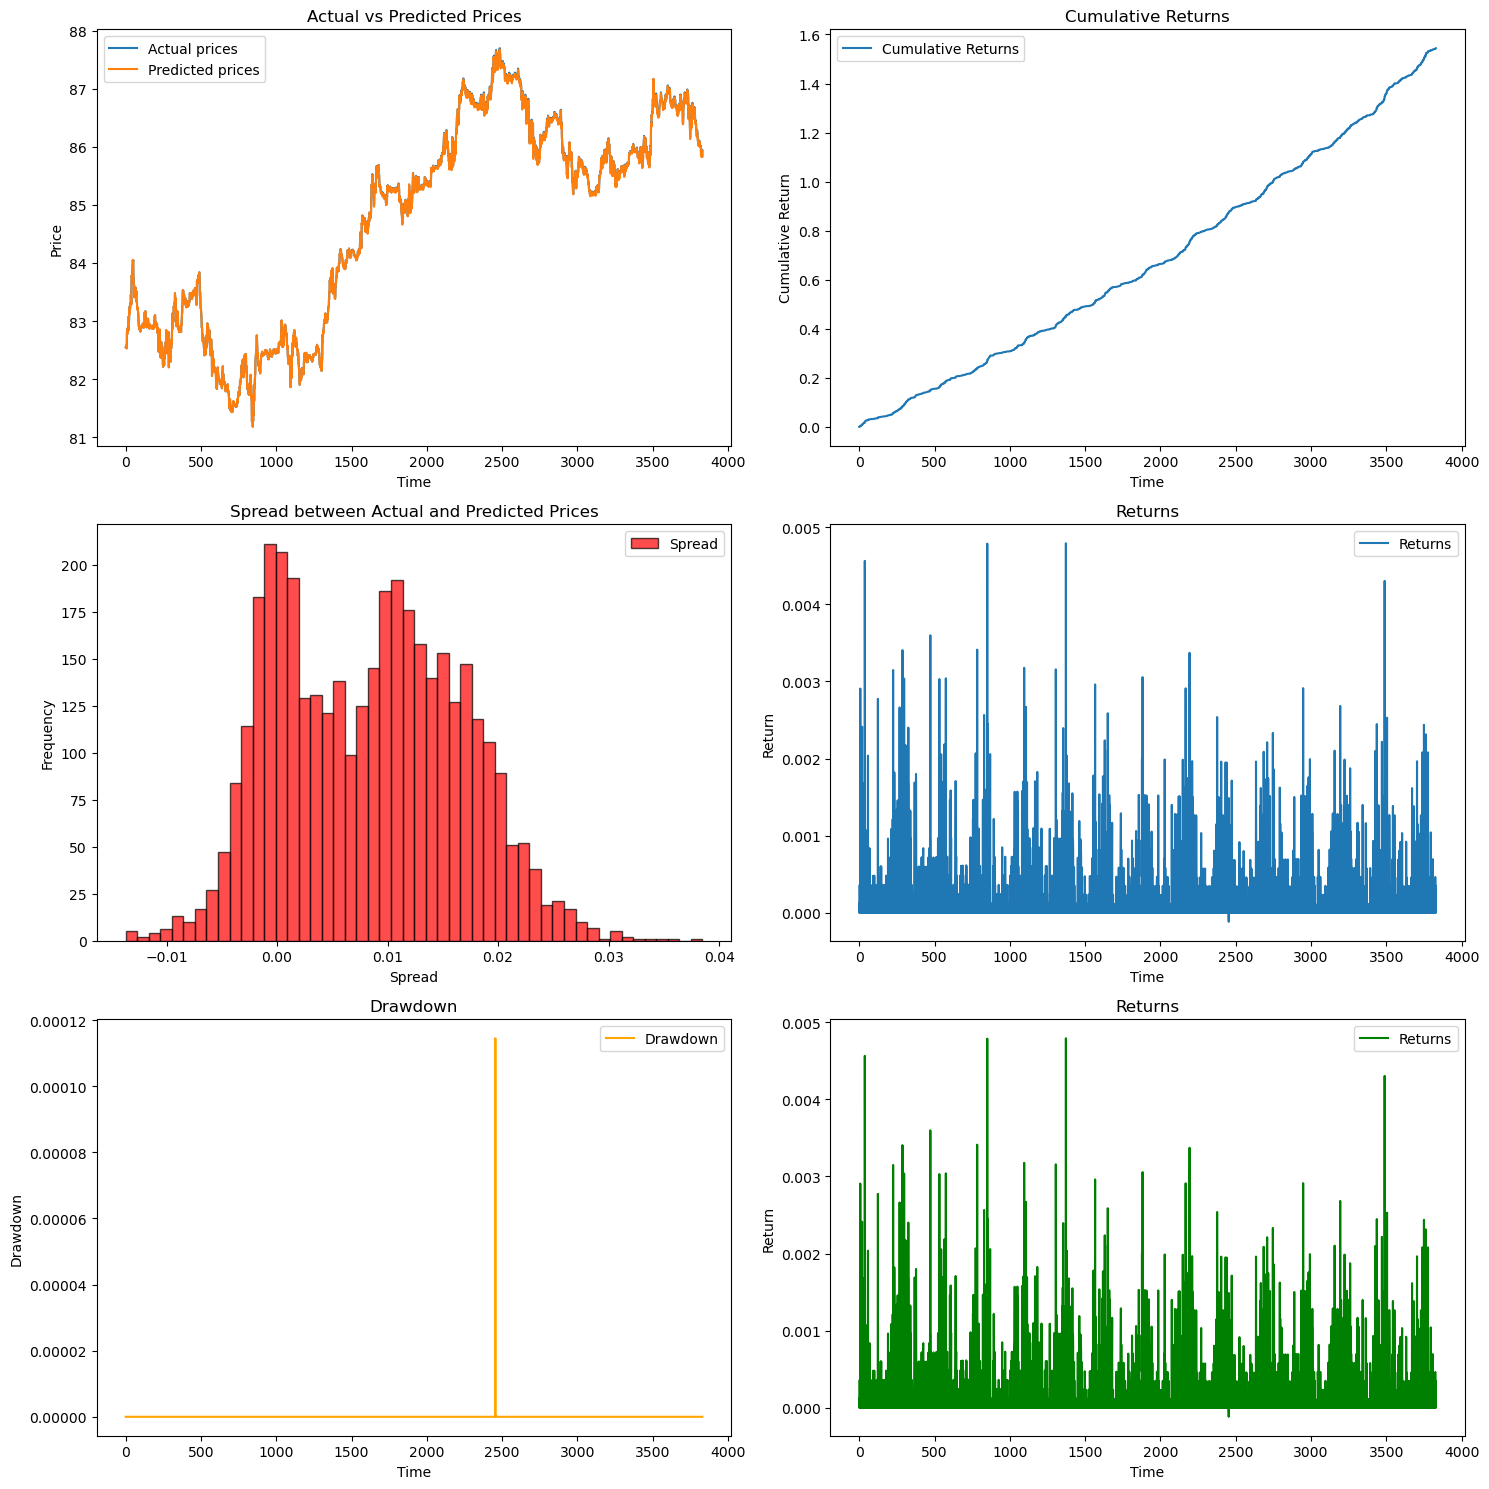

INFO:tensorflow:Assets written to: GRU K-Fold Model\assets


INFO:tensorflow:Assets written to: GRU K-Fold Model\assets


In [148]:
evaluate_model_performance(kfold_gru_models)
kfold_gru_models.save('GRU K-Fold Model')